In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from functools import reduce
from tensorflow import keras

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [4]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/0/'
train_files = [f for f in os.listdir(train_dir) if not f.startswith('.')]
val_dir = './data/FlagsMashupBot/autoencoder_images/val/0/'
val_files = [f for f in os.listdir(val_dir) if not f.startswith('.')]
# test_dir = './data/FlagsMashupBot/autoencoder_images/test/0/'
# test_files = [f for f in os.listdir(test_dir) if not f.startswith('.')]

In [5]:
len(train_files), len(val_files)#, len(test_files)

(5014, 1101)

In [6]:
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/'
val_dir = './data/FlagsMashupBot/autoencoder_images/val/'
# test_dir = './data/FlagsMashupBot/autoencoder_images/test/'
image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(
    train_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
val_data_gen = image_generator.flow_from_directory(
    val_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
# test_data_gen = image_generator.flow_from_directory(
#     test_dir, 
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     target_size=(IMG_HEIGHT, IMG_WIDTH), 
#     class_mode='input')

Found 5014 images belonging to 1 classes.
Found 1101 images belonging to 1 classes.


In [8]:
im_test = image_generator

In [9]:
a = next(train_data_gen)

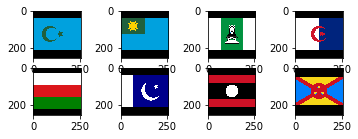

In [10]:
plt.figure()
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE/2, BATCH_SIZE/2, i+1)
    plt.imshow(a[0][i])

In [28]:
img_width, img_height = IMG_WIDTH, IMG_HEIGHT

In [29]:
input_img = Input(shape=(img_width, img_height, 3))

In [30]:
input_img

<tf.Tensor 'input_2:0' shape=(None, 256, 256, 3) dtype=float32>

In [31]:
conv_shape = (3, 3)

In [34]:
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

Tensor("max_pooling2d_9/Identity:0", shape=(None, 32, 32, 16), dtype=float32)


In [35]:
encoded

<tf.Tensor 'max_pooling2d_10/Identity:0' shape=(None, 16, 16, 16) dtype=float32>

In [36]:
x = Conv2D(16, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, conv_shape, activation='sigmoid', padding='same')(x)

In [37]:
decoded

<tf.Tensor 'conv2d_19/Identity:0' shape=(None, 256, 256, 3) dtype=float32>

dimensionality reduction

In [38]:
IMG_HEIGHT * IMG_WIDTH / (reduce(lambda x, y: x*y, np.asarray(encoded.shape[1:])))

16.0

In [39]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0   

In [40]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [41]:
autoencoder_train = autoencoder.fit(
    train_data_gen, 
    epochs=600, 
    shuffle=True,
    validation_data=val_data_gen,
    callbacks=cb)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 627 steps, validate for 138 steps
Epoch 1/600
627/627 [==============================] - 16s 26ms/step - loss: 0.1954 - val_loss: 0.1948
Epoch 2/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1951 - val_loss: 0.1945
Epoch 3/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1947 - val_loss: 0.1941
Epoch 4/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1943 - val_loss: 0.1936
Epoch 5/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1938 - val_loss: 0.1932
Epoch 6/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1934 - val_loss: 0.1927
Epoch 7/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1929 - val_loss: 0.1922
Epoch 8/600
627/627 [==============================] - 16s 25ms/step - loss: 0.1924 - val_loss: 0.1917
Epoch 9/600
627/627 [==============================] - 16s 25ms/step - loss: 0.191

Epoch 78/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0317 - val_loss: 0.0311
Epoch 79/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0315 - val_loss: 0.0308
Epoch 80/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0314 - val_loss: 0.0307
Epoch 81/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0312 - val_loss: 0.0305
Epoch 82/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0310 - val_loss: 0.0303
Epoch 83/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0309 - val_loss: 0.0302
Epoch 84/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0307 - val_loss: 0.0300
Epoch 85/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0305 - val_loss: 0.0299
Epoch 86/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0304 - val_loss: 0.0297
Epoch 87/600
627/627 [==============================] - 16s 25ms

627/627 [==============================] - 16s 25ms/step - loss: 0.0250 - val_loss: 0.0243
Epoch 157/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0249 - val_loss: 0.0243
Epoch 158/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0249 - val_loss: 0.0242
Epoch 159/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0249 - val_loss: 0.0242
Epoch 160/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 161/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 162/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0247 - val_loss: 0.0241
Epoch 163/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 164/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 165/600
627/627 [==============================] - 16s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



627/627 [==============================] - 16s 25ms/step - loss: 0.0227 - val_loss: 0.0220
Epoch 230/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 231/600
627/627 [==============================] - 15s 25ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 232/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 233/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 234/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0225 - val_loss: 0.0219
Epoch 235/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 236/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 237/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 238/600
627/627 [==============================] - 16s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



627/627 [==============================] - 16s 25ms/step - loss: 0.0219 - val_loss: 0.0212
Epoch 270/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0218 - val_loss: 0.0212
Epoch 271/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0218 - val_loss: 0.0211
Epoch 272/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0218 - val_loss: 0.0211
Epoch 273/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0218 - val_loss: 0.0211
Epoch 274/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0218 - val_loss: 0.0211
Epoch 275/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0218 - val_loss: 0.0211
Epoch 276/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0217 - val_loss: 0.0211
Epoch 277/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 278/600
627/627 [==============================] - 16s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



627/627 [==============================] - 16s 25ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 311/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 312/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 313/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 314/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 315/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 316/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0211 - val_loss: 0.0204
Epoch 317/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0211 - val_loss: 0.0204
Epoch 318/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0211 - val_loss: 0.0204
Epoch 319/600
627/627 [==============================] - 16s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



627/627 [==============================] - 16s 25ms/step - loss: 0.0207 - val_loss: 0.0200
Epoch 351/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0207 - val_loss: 0.0200
Epoch 352/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0207 - val_loss: 0.0200
Epoch 353/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0206 - val_loss: 0.0200
Epoch 354/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0206 - val_loss: 0.0199
Epoch 355/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0206 - val_loss: 0.0199
Epoch 356/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0206 - val_loss: 0.0199
Epoch 357/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0206 - val_loss: 0.0199
Epoch 358/600
627/627 [==============================] - 16s 25ms/step - loss: 0.0206 - val_loss: 0.0199
Epoch 359/600
627/627 [==============================] - 16s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
saved = False
if not saved:
    autoencoder.save('./256_model_6000_4.hdf5')
    saved = True

In [45]:
val_images_set = next(val_data_gen)[0]

In [46]:
pred = autoencoder.predict(val_images_set)

In [47]:
pred.shape

(8, 256, 256, 3)

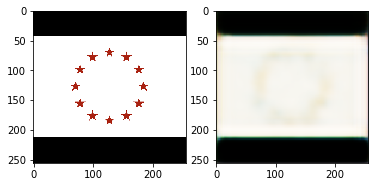

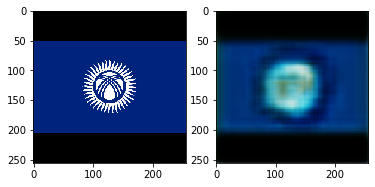

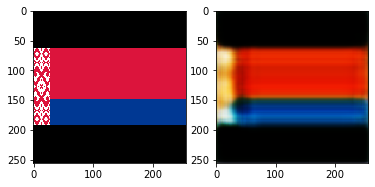

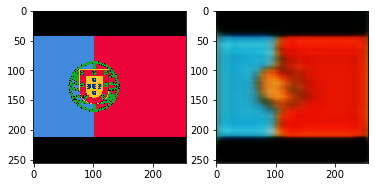

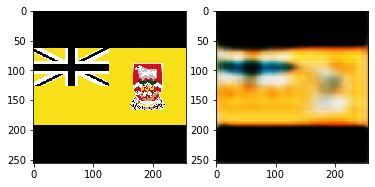

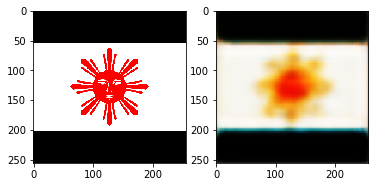

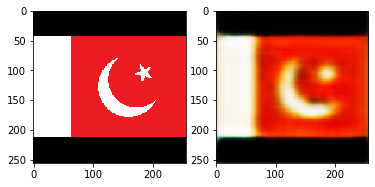

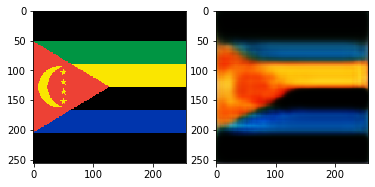

In [48]:
for tr_im, pr_im in zip(val_images_set, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(tr_im)
    plt.subplot(1,2,2)
    plt.imshow(pr_im)    

In [25]:
test_im = Image.open('./data/FlagsMashupBot/reals_square_png/aus.png').convert('RGB')
test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
test_ar = np.asarray(test_im) / 255
test_ar = np.expand_dims(test_ar,0)

In [26]:
pred = autoencoder_train.model.predict(test_ar)

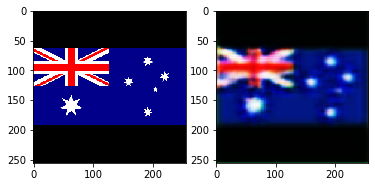

In [27]:
for real, coded in zip(test_ar, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(real)
    plt.subplot(1,2,2)
    plt.imshow(coded)    